In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Simulating Reaction-Diffusion Systems

In this notebook we want to show step by step how to simulate a reaction-diffusion system in Python. Here, we decided for the [Gray-Scott model](http://www.karlsims.com/rd.html) because of the variety of shapes it can produce.

In this models, we have two chemicals $A$ and $B$ which are distributed across a grid of size $N$. The symbol $A_{ij}$ represents the concentration of chemical $A$ at grid coordinates $(i,j)$ (similar for $B$).

The discrete reaction-diffusion update equations are 

$$
\begin{align}
A_{ij}(t+1) &= A_{ij}(t) + \Big[D_A (\nabla^2 A)_{ij} - A_{ij}B_{ij}^2 + f(1-A_{ij}) \Big]\times\Delta t\\
B_{ij}(t+1) &= B_{ij}(t) + \Big[D_B (\nabla^2 B)_{ij} + A_{ij}B_{ij}^2 - (k+f)B_{ij} \Big]\times\Delta t
\end{align}
$$

The single terms are explained in the tutorial linked above.

First, we need to take care of the discretized Laplacian terms. 

## Discrete Laplacian
As explained on [Wikipedia](https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Implementation_via_operator_discretization), the discretized Laplacian of a grid cell $(i,j)$ can be computed by summing over neighboring cells and subtract the value of the original cell with the total weight. One possible implementation is to only recognize direct neighbors of grid difference $\Delta=1$, i.e. at $(i,j-1)$, $(i,j+1)$, $(i-1,j)$, and $(i+1,j)$.

The whole update formula is

$$
(\nabla^2 A)_{ij} = A_{i,j-1} + A_{i,j+1} + A_{i-1,j} + A_{i+1,j} - 4A_{ij}
$$

How can we do this efficiently in `numpy`? Let's first define a small concentration matrix `A`.

In [5]:
A = np.ones((3,3))
A[1,1] = 0
A

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

Now for each cell, we want to add its right neighbor. We can easily access this value in a matrix sense by doing a `numpy.roll`, which shifts all elements in a certain direction, with periodic boundary conditions.

In [6]:
right_neighbor = np.roll(A, # the matrix to permute
                         (0,-1), # we want the right neighbor, so we shift the whole matrix -1 in the x-direction)
                         (0,1), # apply this in directions (y,x)
                        )
right_neighbor

array([[1., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

So to compute the discrete Laplacian of a matrix $M$, one could use the following function.

In [35]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

Let's test this with our example matrix

In [8]:
discrete_laplacian(A)

array([[ 0., -1.,  0.],
       [-1.,  4., -1.],
       [ 0., -1.,  0.]])

Seems like it worked! Note that periodic boundary conditions were used, too.

## Implement update formula

Computing the Laplacian was the hardest part. The other parts are simple. Just take the concentration matrices and apply the update formula.

In [9]:
def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    

## Choosing initial conditions

The initial conditions are very important in the Gray-Scott model. If you just randomize the initial conditions it might happen that everything just dies out. It seems to be a good idea to assume a homogeneous distribution of chemicals with a small disturbance which can then produce some patterns. We can also add a bit of noise. We can do the same decisions as Rajesh Singh in his [somewhat more elaborate version](https://rajeshrinet.github.io/blog/2016/gray-scott/) and disturb with a square in the center of the grid. Let's do the following.

In [10]:
def get_initial_configuration(N, random_influence=0.2):
    
    
    return A, B

Let's also add a function which makes nice drawings and then draw some initial configurations.

In [89]:
def draw(A,B, ax = None):
    """draw the concentrations"""
    if(not ax):
        fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

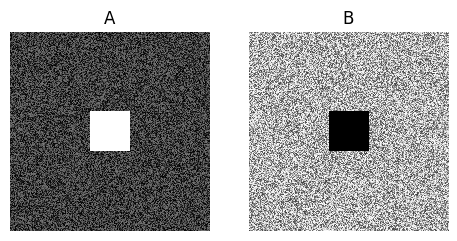

In [45]:
A, B = get_initial_configuration(200)
draw(A,B)

Now we can simulate! We should first decide for some parameter choices. Let's stick with  [Rajesh's choices](https://rajeshrinet.github.io/blog/2016/gray-scott/).

In [33]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.060
k = 0.062

# grid size
N = 200

# simulation steps
N_simulation_steps = 10000

And for the simulation we simply update the concentrations for `N_simulation_steps` time steps.

In [46]:
#DA, DB, f, k = 0.14, 0.06, 0.035, 0.065 # bacteria

    N = 100
    random_influence = 0.2
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell 
    # there's a lot of chemical A, so the concentration is high
    A = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    B = random_influence * np.random.random((N,N))

    # Now let's add a disturbance in the center
    N2 = N//2
    radius = r = int(N/10.0)

    A[N2-r:N2+r, N2-r:N2+r] = 0.50
    B[N2-r:N2+r, N2-r:N2+r] = 0.25
    for t in range(N_simulation_steps):
        """
        Updates a concentration configuration according to a Gray-Scott model
        with diffusion coefficients DA and DB, as well as feed rate f and
        kill rate k.
        """

        # Let's get the discrete Laplacians first
        LA = discrete_laplacian(A)
        LB = discrete_laplacian(B)

        # Now apply the update formula
        diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
        diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

        A += diff_A
        B += diff_B
        
    draw(A,B)

Isn't this nice? You might also want to try the following values (directly taken from Rajesh's version above):

In [72]:
DA, DB, f, k = 0.14, 0.06, 0.035, 0.065 # bacteria
def make_pattern(DA, DB, f, k):
    A, B = get_initial_configuration(200)

    for t in range(N_simulation_steps):
        A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)

    return A, B


[0, 0, 0, 0, 0]

In [102]:
import threading, time, random
nthreads = 5
results = []
# simulates waiting time (e.g., an API call/response)
def slow_function(args):
  DA, DB, f, k = args
  print(f"DA: {DA}, DB: {DB}, f:{f}, k:{k}")
  A, B= make_pattern(DA, DB, f, k)
  results.append([A,B])
  

def run_threads(nthreads):
  threads = []
  params = np.random.uniform(0,0.15, size=(4,nthreads))
  params = np.row_stack([np.arange(5), params])

  for thread_index in range(5):
    individual_thread = threading.Thread(target=slow_function, args=(params[:, thread_index]))
    threads.append(individual_thread)
    individual_thread.start()
  # at this point threads are running independently from the main flow of application and each other
  print("Main flow of application")

  # This ensures that all threads finish before the main flow of application continues
  for individual_thread in threads:
    individual_thread.join()

  print("All threads are done")

run_threads(nthreads)

Exception in thread Thread-75 (slow_function):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-76 (slow_function):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
    self.run()
  File "/usr/local/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
Exception in thread Thread-77 (slow_function):
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self._ta

Main flow of application
All threads are done


DA: 0.09508319658679625, DB: 0.13999103879950917, f:0.11038291406608892, k:0.1366024858233902
DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.013767255126887696

In [106]:
results = []
params = np.random.uniform(0,0.15, size=(4,nthreads))
np.apply_along_axis(slow_function, axis = 0, arr = params,)


DA: 0.01313988689625778, DB: 0.1416141461195286, f:0.005083779856151066, k:0.0026168384308977942
DA: 0.04279492717905514, DB: 0.1282339957281699, f:0.0350092922680094, k:0.009906680778174614
DA: 0.03641569755496741, DB: 0.10684437641295995, f:0.010160255439989557, k:0.14376708513460115
DA: 0.021531476350842172, DB: 0.007395172125323146, f:0.06792637090663567, k:0.12997511243511484
DA: 0.0886188528155762, DB: 0.035070861311768856, f:0.013329929264093316, k:0.054430752660999844


array([None, None, None, None, None], dtype=object)

In [103]:
 
0.14769729064884807, 0.0794623507422214, 0.07322587980760945, 0.013767255126887696

(0.14769729064884807,
 0.0794623507422214,
 0.07322587980760945,
 0.013767255126887696)

In [104]:
p = [0.14769729064884807, 0.0794623507422214, 0.07322587980760945, 0.013767255126887696]

DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.013767255126887696
DA: 0.01313988689625778, DB: 0.1416141461195286, f:0.005083779856151066, k:0.0026168384308977942
DA: 0.04279492717905514, DB: 0.1282339957281699, f:0.0350092922680094, k:0.009906680778174614
DA: 0.03641569755496741, DB: 0.10684437641295995, f:0.010160255439989557, k:0.14376708513460115
DA: 0.021531476350842172, DB: 0.007395172125323146, f:0.06792637090663567, k:0.12997511243511484
DA: 0.0886188528155762, DB: 0.035070861311768856, f:0.013329929264093316, k:0.054430752660999844


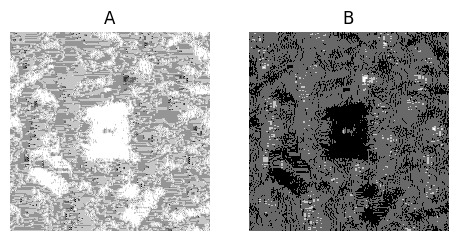

In [110]:
results = []
slow_function(p)
np.apply_along_axis(slow_function, axis = 0, arr = params,)
draw(results[0][0], results[0][1])

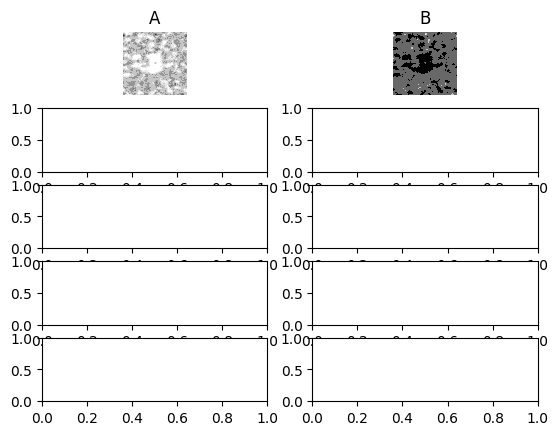

In [90]:

results = []
fig, axs = plt.subplots(nthreads, 2)
for i in range(len(results)):
    p = 
    draw(results[i][0],results[i][1], ax=[axs[i][0], axs[i][1]])

In [113]:
def slow_function(args):
  DA, DB, f, k = args
  print(f"DA: {DA}, DB: {DB}, f:{f}, k:{k}")
  return make_pattern(DA, DB, f, k)

In [163]:

default = [0.14769729064884807, 0.0794623507422214, 0.07322587980760945, 0.013767255126887696]
trial = np.linspace(0.07,0.5, 4)
results = {}
for i in range(4):
        new = default
        new[3] = trial[i]/10
        results[(3,i)] = slow_function(new)

        

DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.007000000000000001
DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.021333333333333336
DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.035666666666666666
DA: 0.14769729064884807, DB: 0.0794623507422214, f:0.07322587980760945, k:0.05


In [136]:
results[(3,2)][0][20].sum()>199.9 and results[(3,2)][0][20].sum()<200

True

In [127]:
200*200

40000

In [ ]:
BAD:
    2 3
    3 0
    3 1
    3 2
    3 3


In [151]:
results[(3,3)]

(array([[0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062],
        [0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062],
        [0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062],
        ...,
        [0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062],
        [0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062],
        [0.13763062, 0.13763062, 0.13763062, ..., 0.13763062, 0.13763062,
         0.13763062]]),
 array([[0.67736295, 0.67736295, 0.67736295, ..., 0.67736295, 0.67736295,
         0.67736295],
        [0.67736295, 0.67736295, 0.67736295, ..., 0.67736295, 0.67736295,
         0.67736295],
        [0.67736295, 0.67736295, 0.67736295, ..., 0.67736295, 0.67736295,
         0.67736295],
        ...,
        [0.67736295, 0.67736295, 0.67736295, ..., 0.67736295, 0.67736295,
         0.67736295],
        [0.6

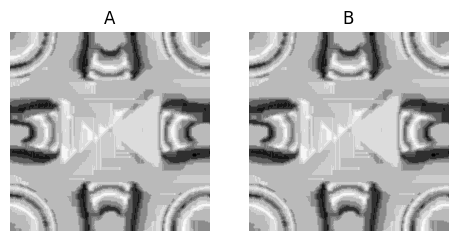

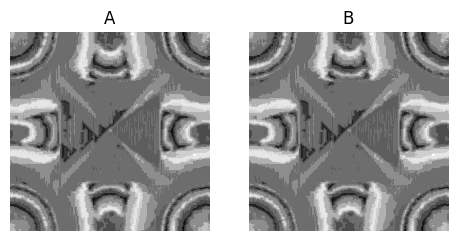

In [164]:
for i in results[(3,3)]:
    draw(i, i)


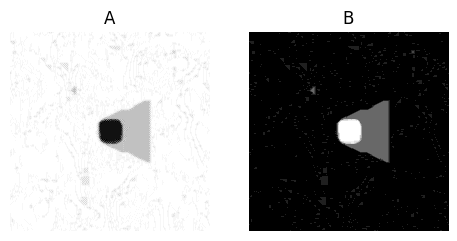

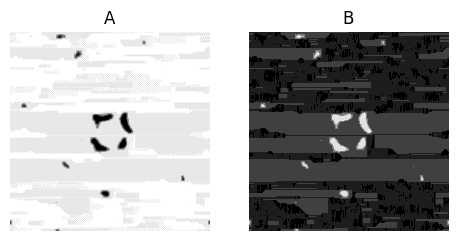

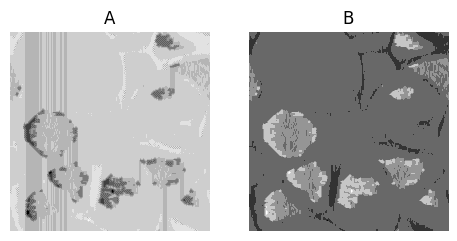

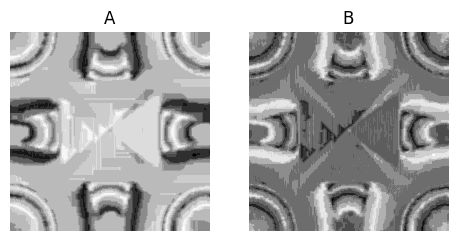

In [165]:

for j in range(4):
        i = 3
        if(np.sum(results[(i,j)][1]) == 0):
            print(i,j)
        elif(results[(i,j)][0][0].sum()>199.9999 and results[(i,j)][0][0].sum()<200):
            print(i,j)
        elif(np.isnan(results[(i,j)][0]).sum()>0):
            print(i,j)
        else:
            draw(results[(i,j)][0], results[(i,j)][1])
